**Utilise Tensorflow v2**

/!\ Attention, avec Tensorflow v2.14, l'installation du GPU ne fonctionne pas

# Paramétrage

## Librairies

**/!\ ATTENTION:** en règle générale, les modèles sauvegardés avec une version donnée de Tensorflow ne peuvent pas être chargés avec les versions suivantes


In [ ]:
!pip install tensorflow==2.15.0 rasterio plotly scikit-image shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 55.8 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import glob
import plotly.express as px
import plotly.graph_objs as go
import cv2
import pandas as pd
import geopandas as gpd
import tqdm
from datetime import date
from google.colab import drive
import random
import matplotlib.pyplot as plt
import shapely
import os
import math

import skimage as ski
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon, label

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

import keras
from keras import layers, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Rescaling, Dense, Dropout, Flatten, Conv2D, Conv2DTranspose, \
MaxPooling2D, AveragePooling2D, SpatialDropout2D, BatchNormalization, Activation, SeparableConv2D, \
UpSampling2D, GlobalAveragePooling2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import load_img, img_to_array, array_to_img


## Données

**Partie spécifique Google Colab**

Si nécessaire, mounter Google Drive

In [ ]:
# partie spécifique Google Colab
!mkdir -p /content/data/decoupe_final
!cp /content/drive/MyDrive/data/DST/df_decoupe_final.csv /content/data/decoupe_final/df_decoupe_final.csv
!unzip /content/drive/MyDrive/data/DST/decoupe_final.zip -d /content/data/decoupe_final

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.cpg  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.dbf  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.jp2  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.prj  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.shp  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.shx  
 extracting: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_data.jpg  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_data.jpg.aux.xml  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_label.png  
  inflating: /content/data/decoupe

Chargement des données image

In [ ]:
data_path = '/content/data/decoupe_final'
images_path = '/content/data/decoupe_final/decoupe_final'
df_decoupe = pd.read_csv(data_path + '/df_decoupe_final.csv')
df_decoupe.head()

dalle_X  dalle_Y         X          Y  X_size  Y_size  \
0        0        0  825000.0  6509800.0    1000    1000   
1        0        1  825000.0  6509600.0    1000    1000   
2        0        2  825000.0  6509400.0    1000    1000   
3        0        3  825000.0  6509200.0    1000    1000   
4        0        4  825000.0  6509000.0    1000    1000   

                          fichier_raster  \
0   69-2020_0_825000.0_0_6509800.0_0.jp2   
1   69-2020_1_825000.0_0_6509600.0_0.jp2   
2   69-2020_2_825000.0_0_6509400.0_4.jp2   
3   69-2020_3_825000.0_0_6509200.0_4.jp2   
4  69-2020_4_825000.0_0_6509000.0_19.jp2   

                                  fichier_img  \
0   69-2020_0_825000.0_0_6509800.0_0_data.jpg   
1   69-2020_1_825000.0_0_6509600.0_0_data.jpg   
2   69-2020_2_825000.0_0_6509400.0_4_data.jpg   
3   69-2020_3_825000.0_0_6509200.0_4_data.jpg   
4  69-2020_4_825000.0_0_6509000.0_19_data.jpg   

                                  fichier_mask  \
0   69-2020_0_825000.0_0_6509800.0_0_label.png   
1   69-2020_1_825000.0_0_6509600.0_0_label.png   
2   69-2020_2_825000.0_0_6509400.0_4_label.png   
3   69-2020_3_825000.0_0_6509200.0_4_label.png   
4  69-2020_4_825000.0_0_6509000.0_19_label.png   

                          fichier_shapes  formes  multi  erreur  
0   69-2020_0_825000.0_0_6509800.0_0.shp       0      0       0  
1   69-2020_1_825000.0_0_6509600.0_0.shp       0      0       0  
2   69-2020_2_825000.0_0_6509400.0_4.shp       4      0       0  
3   69-2020_3_825000.0_0_6509200.0_4.shp       4      0       0  
4  69-2020_4_825000.0_0_6509000.0_19.shp      19      0       0

## Fonctions

In [ ]:
def get_model_results(model, df_train, df_test, train_generator, test_generator, batch_size, saving_path):
  '''
  fonction qui calcule les résultats d'un modèle en utilisant des générateurs de données
  '''
  n_batchs_train = df_train.shape[0] // batch_size
  n_batchs_val = df_test.shape[0] // batch_size
  phase = []
  pred = []
  y = []
  print('calcul des prédictions sur les données d\'entraînement')
  for i in tqdm.tqdm(range(n_batchs_train)):
    images, labels = train_generator.next()
    pred += model.predict(images, verbose=0).flatten().tolist()
    y += labels.flatten().tolist()
    phase += ['train']*len(labels)

  print('calcul des prédictions sur les données de validation')
  for i in tqdm.tqdm(range(n_batchs_val)):
    images, labels = test_generator.next()
    pred += model.predict(images, verbose=0).flatten().tolist()
    y += labels.flatten().tolist()
    phase += ['validation']*len(labels)
  df_model_results = pd.DataFrame({
      'target': y,
      'prediction': pred,
      'phase': phase
  })
  df_model_results.to_csv(saving_path, index = False)
  return(df_model_results)

In [ ]:
def get_Unet_model(img_size, num_classes):
  '''
  fonction qui crée un modèle Unet
  '''

  tf.keras.mixed_precision.set_global_policy('float32')
  inputs = Input((Resolution,Resolution,3))

  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.4)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.4)(conv5)

  up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(6, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(num_classes, 1, activation = 'softmax')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model


In [ ]:
def calcul_IoU(masque1, masque2, min_pixel = 1):
  if not masque1.shape==masque2.shape:
    print("masques de tailles incompatibles")
    return None
  else:
    M1 = masque1 > 0
    M2 = masque2 > 0
    return (min_pixel + np.sum(M1 & M2))/(min_pixel + np.sum(M1 | M2))

In [ ]:
def calcul_precision_recall(true_masque, pred_masque):
  if not true_masque.shape==pred_masque.shape:
    print("masques de tailles incompatibles")
    return None
  else:
    M_true_masque = true_masque > 0
    M_pred_masque = pred_masque > 0
    true_masque_0 = true_masque == 0
    pred_masque_0 = pred_masque == 0
    true_p = M_true_masque & M_pred_masque
    false_p = true_masque_0 & M_pred_masque
    false_n = M_true_masque & pred_masque_0
    # Recall = 1 when FN=0, since 100% of the TP were discovered
    if false_n.numpy().sum() == 0:
      recall = 1
    else:
      recall = true_p.numpy().sum()/(true_p.numpy().sum() + false_n.numpy().sum())
    # Precision = 1 when FP=0, since there were no spurious results
    if false_p.numpy().sum() == 0:
      precision = 1
    else:
      precision = true_p.numpy().sum()/(true_p.numpy().sum() + false_p.numpy().sum())
    return precision, recall

In [ ]:
def compare_ligne(df, chemin_images, index_l, resolution, affichage = True, binaire = False, img_norm = False, img_centrage = None, img_BGR = False, seuil = None):
  '''
  la fonction calcule et renvoie dans cet ordre :
  m_IoU, m_IoU_keras, m_sca, m_scce, precision, recall
  paramètres :
  - df : dataframe avec les informations de découpe
  - chemin_images : répertoire où sont stockées les images
  - index_l : numéro de ligne du dataframe
  - resolution : au format (hauteur, largeur)
  - affichage : si True, génération d'un graphique avec l'image, le masque, et le masque prédit
  - binaire : si le modèle est binaire, sinon 3 classes
  - img_norm : si l'image imput est normée (couleurs divisés par 255)
  - img_centrage : si définit, valeurs du pixel retranchée à tous les pixels de l'image founie au modèle
  - img_BGR : conversion RGB vers BGR
  - seuil : /!\ ne fonctionne que si l'on est en binaire, les classes "bâtiment" ne sont comptées que pour les valeurs supérieures au seuil
  '''
  file_name = chemin_images + df.loc[index_l,'fichier_img']
  mask_name = chemin_images + df.loc[index_l,'fichier_mask']

  # Image
  image = tf.io.read_file(file_name)
  image = tf.image.decode_png(image, channels = 3)
  img_reduite = tf.image.resize(images = image, size = resolution)
  if img_BGR:
    img_reduite = img_reduite[..., ::-1]
  if img_centrage is not None:
    img_reduite = img_reduite - tf.constant([img_centrage])
  if img_norm:
    img_reduite /= 255

  # Masque
  image_mask = tf.io.read_file(mask_name)
  image_mask = tf.image.decode_png(image_mask, channels = 1)
  if binaire :
    image_mask = tf.where(tf.math.greater(image_mask, 0), 1, 0)
  mask_reduit = tf.squeeze(tf.image.resize(images = image_mask, size = resolution))

  # Prévision
  prevision = tf.squeeze(model.predict(tf.expand_dims(img_reduite, 0), verbose=0))
  if seuil is None:
    prev_mask = tf.argmax(prevision, axis=-1)
    if binaire :
      prev_mask = tf.where(tf.math.greater(prev_mask, 0), 1, 0)
  else:
    # /!\ le seuil ne fonctionne qu'avec le mode binaire
    assert binaire
    # on somme toutes les probabilités de la 2e classe et des suivantes le cas échéant
    prev_mask = tf.where(tf.math.greater(tf.reduce_sum(prevision[:,:,1:], -1), seuil), 1, 0)

  # Métriques
  m_mask_reduit = tf.expand_dims(mask_reduit, -1)
  m_prev_mask = tf.expand_dims(prev_mask, -1)
  # Métrique IoU
  m_IoU = calcul_IoU(m_mask_reduit, m_prev_mask)
  # calcul avec Keras pour comparaison
  if binaire:
    nb_classes = 2
  else:
    nb_classes = 3
  iou = keras.metrics.MeanIoU(nb_classes, ignore_class = 0)
  iou.update_state(m_mask_reduit, m_prev_mask)
  m_IoU_keras = iou.result().numpy()
  # Métrique SparseCategoricalCrossEntropy
  scce = keras.losses.SparseCategoricalCrossentropy()
  m_scce = scce(m_mask_reduit, prevision).numpy()
  # Métrique SparseCategoricalAccuracy
  sca = keras.metrics.SparseCategoricalAccuracy()
  sca.update_state(m_mask_reduit, prevision)
  m_sca = sca.result().numpy()
  # Métriques precision & recall
  precision, recall = calcul_precision_recall(m_mask_reduit, m_prev_mask)

  # Affichages
  if affichage:
    print("Numéro image = ", index_l)
    print("Nombre de formes = ", df.loc[index_l,'formes'])
    print(file_name)
    print(mask_name)
    print(">> IoU = ", m_IoU)
    print(">> IoU (Keras) = ", m_IoU_keras)
    print(">> Accuracy = ", m_sca)
    print(">> CrossEntropy = ", m_scce)
    print(">> Precision = ", precision)
    print(">> Recall = ", recall)
    px.imshow(image).show()
    px.imshow(mask_reduit*255).show()
    px.imshow(prev_mask*255).show()

  # Fin
  return m_IoU, m_IoU_keras, m_sca, m_scce, precision, recall

## Configuration du GPU

In [ ]:
list_GPUs = tf.config.list_physical_devices('GPU')
if len(list_GPUs) == 0:
  raise SystemError('aucun GPU trouvé')
print('liste des GPU: {}'.format(list_GPUs))

# Modèle Unet


## Configuration et pré-traitement des données

In [ ]:
resolution = (512, 512)
batch_size = 16
SEED = 77

In [ ]:
def preprocessing_mask(mask):
    mask = tf.clip_by_value(mask, clip_value_min=0, clip_value_max=1)
    return tf.cast(mask, tf.int32)

In [ ]:
def load_and_preprocess(img_filepath, mask_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [Resolution, Resolution], method = "nearest")

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [Resolution, Resolution], method = "nearest")

    img = tf.cast(img, tf.float32)/ 255.0
    return img, mask

In [ ]:
df_train, df_test = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)

# données entraînement
train_img_datagen = ImageDataGenerator(rescale=1./255)
train_mask_datagen = ImageDataGenerator(fill_mode="constant")
train_img_gen=train_img_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory="data/",
                                            x_col="fichier_img",
                                            class_mode=None,
                                            seed = Tirage_alea,
                                            target_size=(Resolution, Resolution),
                                            batch_size=Batch_size)
train_mask_gen=train_mask_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory="data/",
                                            x_col="fichier_mask",
                                            class_mode=None,
                                            seed = Tirage_alea,
                                            target_size=(Resolution, Resolution),
                                            batch_size=Batch_size,
                                            cval=2,
                                            preprocessing_function=preprocessing_mask,
                                            color_mode = "grayscale")

# données test
test_img_datagen = ImageDataGenerator(rescale=1./255)
test_mask_datagen = ImageDataGenerator(fill_mode="constant")
test_img_gen=test_img_datagen.flow_from_dataframe(dataframe=df_test,
                                            directory="data/",
                                            x_col="fichier_img",
                                            class_mode=None,
                                            seed = Tirage_alea,
                                            target_size=(Resolution, Resolution),
                                            batch_size=Batch_size)
test_mask_gen=test_mask_datagen.flow_from_dataframe(dataframe=df_test,
                                            directory="data/",
                                            x_col="fichier_mask",
                                            class_mode=None,
                                            seed = Tirage_alea,
                                            target_size=(Resolution, Resolution),
                                            batch_size=Batch_size,
                                            cval=2,
                                            preprocessing_function=preprocessing_mask,
                                            color_mode = "grayscale")

# assemblage des générateurs
train_generator = zip(train_img_gen, train_mask_gen)
test_generator = zip(test_img_gen, test_mask_gen)

Train Dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>
Validation Dataset:  <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None))>


In [ ]:
# validation
input_img_paths_test = [os.path.join(images_path, file_name) for file_name in df_test['fichier_img'].values]
mask_img_paths_train = [os.path.join(images_path, file_name) for file_name in df_test['fichier_mask'].values]

test_dataset = tf.data.Dataset.from_tensor_slices((input_img_paths_test, mask_img_paths_train))
test_dataset = (
    test_dataset
    .map(load_and_preprocess, num_parallel_calls=-1)
    .batch(Batch_size)
    .prefetch(-1)
)

## Création du modèle et entraînement

In [ ]:
model = get_Unet_model(resolution, 3)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'loss',
                        min_delta = 0.005,
                        patience = 3,
                        factor = 0.2,
                        cooldown = 3,
                        verbose = 1)

model.compile(optimizer = Adam(learning_rate=1e-3),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['SparseCategoricalAccuracy'])
model.summary()


In [ ]:
today_date = date.today().strftime('%Y%m%d')

callbacks = [
    ModelCheckpoint(
        filepath = '/content/drive/MyDrive/DataScientest/Keras/Unet_model_512_' + today_date  + '.keras',
        monitor='val_loss',
        mode='min',
        save_best_only = True)]

history = model.fit(train_generator,
                    epochs = 50,
                    callbacks = callbacks,
                    batch_size = batch_size,
                    validation_data = test_dataset)

model.save('/content/drive/MyDrive/DataScientest/Keras/Unet_model_512_' + today_date + '.keras')
np.save('/content/drive/MyDrive/DataScientest/Keras/history_Unet_model_512_' + today_date + '.npy', history.history)


## Résultats

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/Keras/Unet_model_binary_20240106.keras')


17 forme(s) détectée(s) pour 3 forme(s) présente(s)


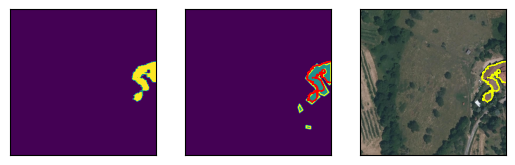

In [ ]:
i_image = 6
show_segmentation_results(model, i_image, df_decoupe)

## Statistiques

In [ ]:
SIZE = 512
RESOLUTION = (SIZE, SIZE)
NUM_CLASSES = 2
BINARY_MASK = True
BATCH_SIZE = 16
SEED = 77

In [ ]:
model = load_model('/content/drive/MyDrive/DataScientest/Keras/Unet_model_binary_20240106.keras')


In [ ]:
_, df_metrique = train_test_split(df_decoupe, test_size=0.2, random_state=SEED)
df_metrique = df_metrique.reset_index()


In [ ]:
compare_ligne(
    df_metrique, images_path + '/', 34,
    resolution = RESOLUTION, affichage = True, binaire = True,
    img_norm = False, img_centrage = None, img_BGR = False)

Numéro image =  34
Nombre de formes =  48
/content/data/decoupe_final/decoupe_final/69-2020_4_835000.0_0_6514000.0_48_data.jpg
/content/data/decoupe_final/decoupe_final/69-2020_4_835000.0_0_6514000.0_48_label.png
>> IoU =  0.6440982194141298
>> IoU (Keras) =  0.4352979
>> Accuracy =  0.94067
>> CrossEntropy =  0.12930492
>> Precision =  0.885904272829021
>> Recall =  0.7023514366991153


(0.6440982194141298,
 0.4352979,
 0.94067,
 0.12930492,
 0.885904272829021,
 0.7023514366991153)

In [ ]:
metriques = []
for i in tqdm.tqdm(range(df_metrique.shape[0])):
    metriques.append(list(compare_ligne(df_metrique, images_path + '/', i, resolution = RESOLUTION, affichage = False, binaire = True, img_norm = False, img_centrage = None, img_BGR = False)))

df_metrique['IoU'] = np.array(metriques)[:,0]
df_metrique['IoU_Keras'] = np.array(metriques)[:,1]
df_metrique['sca'] = np.array(metriques)[:,2]
df_metrique['scce'] = np.array(metriques)[:,3]
df_metrique.to_csv('/content/drive/MyDrive/DataScientest/Keras/Unet_binary_metriques_20240106.csv')

100%|██████████| 1500/1500 [08:06<00:00,  3.08it/s]



Moyenne IoU =  0.5628607047503368
Moyenne IoU Keras =  0.26020152850324907
Moyenne SCA =  0.9462597681681315
Moyenne SCCE =  0.15406375938370062


In [ ]:
df_metrique = pd.read_csv('/content/drive/MyDrive/DataScientest/Keras/Unet_binary_metriques_20240106.csv')
print('')
print("Moyenne IoU = ", df_metrique.IoU.mean())
print("Moyenne IoU Keras = ", df_metrique.IoU_Keras.mean())
print("Moyenne SCA = ", df_metrique.sca.mean())
print("Moyenne SCCE = ", df_metrique.scce.mean())

In [ ]:
fig = px.scatter(df_metrique, x='formes',y=['IoU', 'IoU_Keras','sca'], title="Analyse des métriques modèle Unet (06.01)")
fig.update_layout(
    xaxis=dict(title='Nbr formes',),
    yaxis=dict(title='Métrique',),
    legend=dict(title="Métrique")
)
fig.show()

In [ ]:
fig = px.histogram(df_metrique, x='IoU', nbins=40, title="Analyse IoU modèle Unet (06.01)")
fig.update_layout(
    xaxis=dict(title='IoU',),
    yaxis=dict(title='Count',))
fig.update_layout(bargap=0.1)
fig.show()

### Sensibilité au seuil de détection

Calcul de l'évolution des métriques en faisant varier le seuil de détection

In [ ]:
seuils = np.arange(0, 1.05, 0.05)
metriques = []
metriques_list = ['IoU', 'IoU_Keras', 'sca', 'scce', 'precision', 'recall', 'formes']
for seuil in tqdm.tqdm(seuils):
  for i in range(df_metrique.shape[0]):
    metriques.append(list(compare_ligne(
        df_metrique, images_path + '/', i,
        resolution = RESOLUTION, affichage = False, binaire = True,
        img_norm = False, img_centrage = None, img_BGR = False,
        seuil = seuil)) + [df_metrique['formes'].values[i]])
df_metriques_seuils = pd.DataFrame({
    'seuil': np.repeat(seuils, df_metrique.shape[0]*len(metriques_list)),
    'valeur': np.array(metriques).flatten(),
    'metrique': metriques_list*df_metrique.shape[0]*len(seuils)
})
df_metriques_seuils.to_csv('/content/drive/MyDrive/DataScientest/Keras/Unet_binary_metriques_seuil_20240106.csv')


100%|██████████| 21/21 [2:39:04<00:00, 454.49s/it]


In [ ]:
fig_seuils = px.line(
    df_metriques_seuils.groupby(['seuil', 'metrique']).agg({'valeur':'mean'}).reset_index().query("metrique in ['IoU', 'IoU_Keras']"),
    x = 'seuil',
    y = 'valeur',
    color = 'metrique')
fig_seuils.update_layout(
    title = 'IoU en fonction du seuil<br>modèle Unet (06.01)',
    plot_bgcolor='white',
    height = 600,
    width = 600)
fig_seuils.show()

In [ ]:
fig_PR = px.line(
    df_metriques_seuils.groupby(['seuil', 'metrique']).agg({'valeur':'mean'}).reset_index().pivot(index = ['seuil'], columns = ['metrique'], values = 'valeur').reset_index(),
    x = 'recall',
    y = 'precision',
    hover_data=['seuil'])
fig_PR.update_layout(
    title = 'Courbe PR modèle Unet (06.01)',
    plot_bgcolor='white',
    height = 600,
    width = 600)
fig_PR.show()

### Contours

Calcul des métriques évoluées de contours basées sur les formes

In [ ]:
def predict_Unet(file_name, model, seuil):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_png(image, channels = 3)
  img_reduite = tf.image.resize(images = image, size = RESOLUTION)
  img_reduite /= 255

  prevision = tf.squeeze(model.predict(tf.expand_dims(img_reduite, 0), verbose=0))
  prev_mask = tf.where(tf.math.greater(tf.reduce_sum(prevision[:,:,1:], -1), seuil), 1, 0)
  return [prev_mask]

def calcul_ious_shapes(shapes_1_ext, shapes_2_ext):
  '''
  fonction qui calcule l'IoU des shapes_1_ext en cherchant à rapprocher les shapes_2_ext
  renvoie la liste des ious calculés
  '''
  ious = []
  rapprochements = []
  for i in range(len(shapes_1_ext)):
    shape_1 = shapely.Polygon(shapes_1_ext[i])
    unions = []
    unions.append(shape_1)
    intersections = []
    for j in range(len(shapes_2_ext)):
      shape_2 = shapely.Polygon(shapes_2_ext[j])
      if shape_2 is not None:
        if shape_1.intersects(shape_2):
          intersection = shape_1.intersection(shape_2)
          intersections.append(intersection)
          unions.append(shape_2)
    if len(intersections) > 0:
      intersection_area = shapely.area(gpd.GeoSeries(intersections, crs = 2154).unary_union)
    else:
      intersection_area = 0
    union_area = shapely.area(gpd.GeoSeries(unions, crs = 2154).unary_union)
    if union_area == 0:
      ious.append(0)
    else:
      ious.append(intersection_area/union_area)
    rapprochements.append(len(intersections))
  return ious, rapprochements

def affiche_contours(
    model, predict_function, df, chemin_images, index_l, resolution_model, resolution_target = (1000, 1000),
    seuil = None, seuil_iou = 0, gdf_shapes_ref = None, affichage = True,
    seuil_area = 10,
    tolerance_polygone = 0.1):
  '''
  fonction qui calcule les IoU des formes prédites par rapport à des formes de référence
  utilise les mêmes arguements que compare_ligne, avec en plus :
  - predict_function : fonction qui prend en argument le triplet (file_name, model, seuil) et qui renvoie une liste de prévisions du modèle "model" sous forme
  de masque numpy.array avec les dimensions correspondant au paramètre "resolution_model", pour le seuil de détection "seuil"
  - seuil_iou : les formes avec un IoU inférieur sont affichées en rouge
  - gdf_shapes_ref : fichier de shapefiles à utiliser pour la comparaison des formes prédites > par défaut, on compare par rapport aux formes du df_decoupe
  renvoie :
  - geoSeries avec les formes prédites, crs 2154, avec uniquement les contours
  - geoSeries avec les formes de réference, crs 2154, avec uniquement les contours, et en fusionnant les formes adjacentes
  - shapes_pred_ious
  - shapes_ref_ious
  '''
  file_name = chemin_images + df.loc[index_l,'fichier_img']
  raster_name = chemin_images + df.loc[index_l, 'fichier_raster']
  shape_name = chemin_images + df.loc[index_l, 'fichier_shapes']

  # Prévision
  prev_masks = predict_function(file_name, model, seuil)
  # Contours prédiction
  mask_contours = []
  for prev_mask in prev_masks:
    prev_mask_resized = tf.squeeze(tf_image.resize(images = np.expand_dims(prev_mask, -1), size = resolution_target, method = 'nearest'))
    mask_padded = np.pad(prev_mask_resized, ((1, 1),(1, 1)), mode = 'constant', constant_values = 0)
    mask_contours += ski.measure.find_contours(image = mask_padded == 1)

  # Shapes prédiction
  with rasterio.open(raster_name) as raster:
    # création du convertisseur pour passer des coordonnées en pixels
    raster_transform = raster.transform
    raster_transformer = rasterio.transform.AffineTransformer(raster_transform)
    shapes_xy = []
    shapes_predict = []
    # parcours de tous les contours prédits
    for contour in mask_contours:
      # on crée le polygone
      polygon = approximate_polygon(contour, tolerance = tolerance_polygone)
      # on tranforme en coordonnées
      xy_polygon = raster_transformer.xy(polygon[:,0], polygon[:,1])
      shapes_xy.append(xy_polygon)
      # on crée le polygone
      shapes_predict.append(shapely.Polygon(np.array(xy_polygon).transpose()))
  # on filtre les surface trop petites
  shapes_predict = [shape for shape in shapes_predict if shapely.area(shape) > seuil_area]
  # Ajout des trous dans les shapes prédiction
  shapes_predict_holes = []
  shapes_holes = []
  for shape_a in shapes_predict:
    if shape_a not in shapes_holes:
      shape_a_holes = []
      for shape_b in shapes_predict:
        if shape_a.contains_properly(shape_b):
          shape_a_holes.append(shape_b.exterior)
          shapes_holes.append(shape_b)
      if len(shape_a_holes) > 0:
        shapes_predict_holes.append(shapely.Polygon(shape_a.exterior, holes = shape_a_holes))
      else:
        shapes_predict_holes.append(shape_a)
  gdf_shapes_predict = gpd.GeoDataFrame(geometry = gpd.GeoSeries(shapes_predict_holes, crs=2154), crs=2154)
  # gdf_shapes_predict = gdf_shapes_predict[gdf_shapes_predict['geometry'].is_valid].reset_index()

  # Shapes référence
  if gdf_shapes_ref is None:
    gdf_shapes_ref = gpd.read_file(shape_name)
  # gdf_shapes_ref = gdf_shapes_ref[gdf_shapes_ref['geometry'].is_valid].reset_index()
  # /!\ on court-circuite le traitement pour éviter de supprimer des formes de référence
  '''
  # Regroupement et fusion des formes adjacentes
  gdf_shapes_ref['group'] = ''
  for index in range(gdf_shapes_ref.shape[0]):
    group = gdf_shapes_ref[~gdf_shapes_ref.geometry.disjoint(gdf_shapes_ref.geometry[index])].index.to_list()
    if len(group) > 1:
      if gdf_shapes_ref.loc[index, 'group'] == '':
        gdf_shapes_ref.loc[group, 'group'] = 'group_' + str(index)
      else:
        gdf_shapes_ref.loc[group, 'group'] = gdf_shapes_ref.loc[index, 'group']
  gdf_shapes_ref_merged = gdf_shapes_ref.dissolve(by = 'group', as_index = False)
  gdf_shapes_ref_merged = gdf_shapes_ref_merged[gdf_shapes_ref_merged['geometry'].is_valid].reset_index()
  '''

  # Intersection et IoUs
  shapes_ref = gdf_shapes_ref['geometry'].exterior
  shapes_ref = [shape for shape in shapes_ref if shape is not None]
  shapes_predict = gdf_shapes_predict['geometry'].exterior
  shapes_predict = [shape for shape in shapes_predict if shape is not None]
  # iou des prédictions
  shapes_pred_ious, shapes_pred_rapprochements = calcul_ious_shapes(shapes_predict, shapes_ref)
  # iou des réferences
  shapes_ref_ious, shapes_ref_rapprochements = calcul_ious_shapes(shapes_ref, shapes_predict)

  fig = None
  if affichage:
    # lecture du raster
    raster_file = chemin_images + df.loc[index_l,'fichier_raster']
    with rasterio.open(raster_file) as raster:
        bounds = raster.bounds
        raster_data = np.transpose(raster.read(), [1,2,0])

    # génération du graphique
    X0 = df.loc[index_l, 'X']
    Y0 = df.loc[index_l, 'Y']
    dalle_X = df.loc[index_l, 'dalle_X']
    dalle_Y = df.loc[index_l, 'dalle_Y']
    nb_formes = df.loc[index_l, 'formes']
    fig = px.imshow(
        cv2.flip(raster_data, 0),
        x = np.linspace(bounds.left, bounds.right, raster.width),
        y = np.linspace(bounds.bottom, bounds.top, raster.height),
        title = 'Image {}, {} ({}, {})<br>{} bâtiments<br>fichier {}<br>{} zones détectées'.format(
            str(X0), str(Y0), str(dalle_X), str(dalle_Y), str(nb_formes), raster_file,
            np.sum((np.array(shapes_pred_ious) <= seuil_iou) & (np.array(shapes_pred_rapprochements) == 0))),
        origin = 'lower')
    # ajout des formes
    shape_traces_to_plot = []
    # formes de référence
    for shape, iou, rapprochement in zip(shapes_ref, shapes_ref_ious, shapes_ref_rapprochements):
      list_x, list_y = shape.xy
      shape_traces_to_plot.append(
          go.Scatter(
              x = np.array(list_x),
              y = np.array(list_y),
              line = dict(color='black', width=1),
              mode = 'lines',
              fill = 'toself',
              fillcolor = '#80b1d3',
              opacity = 0.4,
              text = 'iou référence: {}<br>{} prédictions rapprochées'.format(iou, rapprochement),
              hoverinfo = 'text',
              showlegend = False))
    # formes prédites
    for shape, iou, rapprochement in zip(shapes_predict, shapes_pred_ious, shapes_pred_rapprochements):
      if iou <= seuil_iou:
        color_shape = 'red'
      else:
        color_shape = '#ffed6f'
      list_x, list_y = shape.xy
      shape_traces_to_plot.append(
          go.Scatter(
              x = np.array(list_x),
              y = np.array(list_y),
              line = dict(color='black', width=1),
              mode = 'lines',
              fill = 'toself',
              fillcolor = color_shape,
              opacity = 0.4,
              text = 'iou prédiction: {}<br>{} bâtiments rapprochés'.format(iou, rapprochement),
              hoverinfo = 'text',
              showlegend = False))
    fig.add_traces(shape_traces_to_plot)
    # mise en forme
    fig.update_layout(
        xaxis=dict(title='X en Lambert93'),
        yaxis=dict(title='Y en Lambert93'),
        plot_bgcolor='white',
        height = 900,
        width = 900)

  return shapes_predict, shapes_ref, shapes_pred_ious, shapes_ref_ious, shapes_pred_rapprochements, shapes_ref_rapprochements, fig


In [ ]:
_, _, _, _, _, _, fig = affiche_contours(
    model, predict_Unet, df_decoupe, images_path + '/', 6337,
    RESOLUTION, resolution_target = (1000, 1000),
    seuil = 0.25, seuil_iou = 0.01, gdf_shapes_ref = None, affichage = True,
    seuil_area = 30)
fig.show()

Calcul des TP, FP, FN en faisant varier le seuil de confiance et l'IoU

**1ere méthode**:

+ TP : iou_pred >= seuil_iou
+ FP : iou_pred ~ 0
+ FN : iou_ref ~ 0

Moez-UNet07_res512_23_12_23_metriques_seuil_iou_old.csv


**2e méthode**:

+ TP : iou_pred >= seuil_iou
+ FP : iou_pred < seuil_iou
+ FN : iou_ref < seuil_iou

Moez-UNet07_res512_23_12_23_metriques_seuil_iou.csv

In [ ]:
iou_0 = 0.01
seuils = np.arange(0, 1.05, 0.05)
ious = [0.01, 0.1, 0.2, 0.5, 0.7, 0.85, 0.95]

i_images_list = []
seuils_list = []
seuil_iou_list = []
TP_list = []
FP_list = []
FN_list = []

with tqdm.tqdm(total = len(seuils)*len(ious)*df_metrique.shape[0]) as pbar:
  for i_image in range(df_metrique.shape[0]):
    for seuil_detection in seuils:
      _, _, pred_ious, ref_ious, _, _, _ = affiche_contours(
          model, predict_Unet, df_decoupe, images_path + '/', i_image,
          RESOLUTION, resolution_target = (1000, 1000),
          seuil = seuil_detection, seuil_iou = iou_0, gdf_shapes_ref = None, affichage = False,
          seuil_area = 30)
      for seuil_iou in ious:
        TP_list.append(np.sum(np.array(pred_ious) >= seuil_iou))
        FP_list.append(np.sum(np.array(pred_ious) <= seuil_iou))
        FN_list.append(np.sum(np.array(ref_ious) <= seuil_iou))
        seuils_list.append(seuil_detection)
        seuil_iou_list.append(seuil_iou)
        i_images_list.append(i_image)
        pbar.update(1)

df_metriques_seuils_ious = pd.DataFrame({
    'seuil': seuils_list,
    'seuil_iou' : seuil_iou_list,
    'i_images': i_images_list,
    'TP' : TP_list,
    'FP' : FP_list,
    'FN' : FN_list
})
df_metriques_seuils_ious.to_csv('/content/drive/MyDrive/DataScientest/Keras/Moez-UNet07_res512_23_12_23_metriques_seuil_iou.csv')


 33%|███▎      | 72052/220500 [49:49<1:48:17, 22.85it/s]